<a href="https://colab.research.google.com/github/amandeepsaini/green-screen-anywhere/blob/main/Advanced_Dataset_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import random
import tensorflow.keras.layers as l
from tensorflow.keras.utils import plot_model
from tqdm import tqdm

%matplotlib inline

# Helper Functions

In [3]:
def show_img(img):
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

def show_img_mult(imgs, rows=5, columns=5):
  num_imgs = len(imgs)
  fig = plt.figure(figsize=(20,20))
  for i in range(num_imgs):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
  plt.show()


In [4]:
def square_crop_full(img, start_y=0, start_x=0, resize_to=None):
  """ Return a square crop with the max amount of image that can fit """
  h, w, c = img.shape

  if h > w:
    start_y = max(start_y, 0)
    end_y = min(start_y + w, h)
    start_y = end_y - w
    img_crop = img[start_y:end_y]

  else:
    start_x = max(start_x, 0)
    end_x = min(start_x + h, w)
    start_x = end_x - h
    img_crop = img[:,start_x:end_x]

  if resize_to is not None:
    img_crop = cv2.resize(img_crop, (resize_to, resize_to))

  return img_crop

def square_crop(img, start_y=0, start_x=0, length=160, resize_to=None):
  """ Return a square crop of lenght length, starting at the coordinates given"""
  h, w, c = img.shape
  length = min(h,w,length)

  # ensure start is > 0
  start_y = max(start_y, 0)
  # Ensure end is on the image
  end_y = min(start_y + length, h)
  #recalculate start according to end
  start_y = end_y - length

  # same for x
  start_x = max(start_x, 0)
  end_x = min(start_x + length, w)
  start_x = end_x - length

  img_crop = img[start_y:end_y,start_x:end_x]

  if resize_to is not None:
    img_crop = cv2.resize(img_crop, (resize_to, resize_to))

  return img_crop

In [5]:
# Obtained and adpated from https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image
def overlay_transparent(background, overlay, x, y, return_alpha_mask=False):
    background = background.copy()
    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image
    if return_alpha_mask:
      alpha_mask = np.zeros((background.shape[0], background.shape[0],1)).astype(np.float32)
      alpha_mask[y:y+h, x:x+w] = mask
      return background, alpha_mask

    else:
      return background

In [6]:
def get_frame(vid_cap, frame_num, total_frames=None):
  if total_frames is None:
    total_frames = vid_cap.get(cv2.CAP_PROP_FRAME_COUNT)

  # check for valid frame number
  if frame_num >= 0 & frame_num <= total_frames:
    # set frame position
    vid_cap.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    ret, frame = vid_cap.read()
    return frame
  else:
    print("Frame out of range")
    return None

def get_random_frames(vid_cap, max_frame_distance=100):
    total_frames = vid_cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frame1_index = random.randint(0,total_frames)
    frame1 = get_frame(vid_cap, frame1_index, total_frames)
 
    if max_frame_distance > 0:
      frame2_index = random.randint(max(0, frame1_index - max_frame_distance), 
                                    min(total_frames, frame1_index + max_frame_distance))
      frame2 = get_frame(vid_cap, frame2_index, total_frames)
    else:
      frame2 = frame1
      frame2_index = frame1_index

    # print(total_frames, frame1_index, frame2_index)
    return frame1, frame2

def get_random_frames_from_list(frames, max_frame_distance=100, skip_frames_val=0):
  """ Given a list of frames, return two that are a random distance apart 
  within a given range """
  max_frame_distance = max(0, int(max_frame_distance/(skip_frames_val + 1)))

  total_frames = len(frames)
  frame1_index = random.randint(0,total_frames-1)
  frame1 = frames[frame1_index]

  if max_frame_distance > 0:
    frame2_index = random.randint(max(0, frame1_index - max_frame_distance), 
                                  min(total_frames - 1, frame1_index + max_frame_distance))
    frame2 = frames[frame2_index]
  else:
    frame2 = frame1
    frame2_index = frame1_index

#   print(total_frames, frame1_index, frame2_index)

  return frame1, frame2

def normalize_resolution(img, max_res):
    h,w,c = img.shape
    largest_side = max(h, w)
    if largest_side > max_res:
        downsample_ratio = max_res/largest_side
        img = cv2.resize(img, (0,0), fx=downsample_ratio, fy=downsample_ratio)

    return img 

def extract_frames(vid_cap, skip_frames=0, num_frames=-1, max_res=1080):
  """ Extract and return frames from video as a list """
  vid_frames = []
  max_frames = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT)/(skip_frames + 1))
  if num_frames == -1:
    num_frames = max_frames
  else:
    num_frames = min(num_frames, max_frames)
  for i in tqdm(range(num_frames)):
    for skip in range(skip_frames):
        ret, frame = vid_cap.read()

    ret, frame = vid_cap.read()
    if frame is None:
        break
    vid_frames.append(normalize_resolution(frame, max_res))
    # vid_frames.append(frame)

  return vid_frames




# Augmentations

In [7]:
import imgaug as ia
import imgaug.augmenters as iaa

seq = iaa.Sequential([

    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05)),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2)),
], random_order=True) # apply augmenters in random order

seq2 = iaa.Sequential([
    iaa.LinearContrast((0.75, 1.5)),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
], random_order=True)


def augment(imgs):
  return seq(images=imgs)

def augment_alpha_images(imgs, augment_it=False, resize=False):

    if augment_it:
        alpha_channels = [img[:,:,3] for img in imgs]
        rgb_channels = [img[:,:,:3] for img in imgs]
        rgb_channels = seq(images=rgb_channels)

        imgs = [np.concatenate((rgb, np.expand_dims(a, axis=2)), axis=-1) for rgb, a in 
                zip(rgb_channels, alpha_channels)]

    if resize:
        for i, img in enumerate(imgs):
            rand_rescale = random.uniform(.7,1.0)
            img = cv2.resize(img, (0,0), fx=rand_rescale, 
                                fy=rand_rescale,interpolation=cv2.INTER_CUBIC)
            imgs[i] = img

    return imgs

# Generator

In [8]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size=16, epoch_len=1000, video_filepaths=[], 
                 overlay_paths=[], resize_res=160, 
                 resize_overlay=True, augment_input1=True, 
                 augment_input2=True, augment_overlay= True, 
                 max_size_overlay = 100, max_frame_distance=100, 
                 skip_frames_val=4, max_frame_count=100, 
                 max_res_bgs=1080, **kwargs):
        super().__init__(**kwargs)

        self.batch_size = batch_size
        self.epoch_len = epoch_len
        self.resize_res = resize_res
        self.resize_overlay = resize_overlay
        self.augment_input1 = augment_input1
        self.augment_input2 = augment_input2
        self.augment_overlay = augment_overlay
        self.max_size_overlay = max_size_overlay

        self.max_frame_distance = max_frame_distance
        self.skip_frames_val = skip_frames_val
        self.max_frame_count = max_frame_count
        self.max_res_bgs = max_res_bgs


        self.prepare_video_files(video_filepaths)
        self.prepare_overlays(overlay_paths)

    def __len__(self):
        return self.epoch_len

    def normalize_overlay_size(self, overlay):
        h,w,c = overlay.shape
        largest_side = max(h, w)
        if largest_side > self.max_size_overlay:
            downsample_ratio = self.max_size_overlay/largest_side
            overlay = cv2.resize(overlay, (0,0), fx=downsample_ratio, fy=downsample_ratio)

        return overlay 

    def prepare_overlays(self, overlay_paths):
        self.overlays = []
        for path in overlay_paths:
            overlay = cv2.imread(path, cv2.IMREAD_UNCHANGED)
            overlay = self.normalize_overlay_size(overlay)
            self.overlays.append(overlay)

    def prepare_video_files(self, video_filepaths):
        self.videos_list = []
        for vid_filepath in video_filepaths:
            print("\nProcessing Video", vid_filepath.split("/")[-1])
            video = cv2.VideoCapture(vid_filepath)
            self.videos_list.append(extract_frames(video, 
                                                skip_frames=self.skip_frames_val, 
                                                num_frames=self.max_frame_count,
                                                max_res=self.max_res_bgs))

    def get_rand_frame_from_vid(self):
        rand_index = random.randint(0, len(self.videos_list)-1)
        rand_vid = self.videos_list[rand_index]
        frame1, frame2 = get_random_frames_from_list(rand_vid, 
                              max_frame_distance=self.max_frame_distance, 
                              skip_frames_val=self.skip_frames_val)
        return frame1, frame2
    
    def get_square_cropped(self, imgs):
        """ Given a list of images, return each randomly cropped at the same 
        location. Works best for images of the same size """
        h, w, c = imgs[0].shape
        max_length = min(h, w)
        length = random.randint(self.resize_res, max_length)

        start_y = random.randint(0, h - length)
        start_x = random.randint(0, w - length)
        cropped = [square_crop(img, start_y=start_y, start_x=start_x, length=length, 
                               resize_to=self.resize_res) for img in imgs]
        
        return cropped

    def __getitem__(self, index):
        batch_input1 = np.zeros((self.batch_size, self.resize_res, 
                                 self.resize_res,3)).astype(np.float32)
        batch_input2 = np.zeros_like(batch_input1)
        batch_labels = np.zeros((self.batch_size, self.resize_res, 
                                 self.resize_res,1)).astype(np.float32)

        input1_list = []
        input2_list = []
        overlay_list = []

        # Get the ramdom frames and overlays
        for i in range(self.batch_size):
            frame1, frame2 = self.get_rand_frame_from_vid()
            frame1, frame2 = self.get_square_cropped([frame1, frame2])
            overlay = random.choice(self.overlays)

            input1_list.append(frame1)
            input2_list.append(frame2)
            overlay_list.append(overlay)
        
        # Perform augments
        if self.augment_input1:
            input1_list = augment(input1_list)
        if self.augment_input2:
            input2_list = augment(input2_list)

        overlay_list = augment_alpha_images(overlay_list, self.augment_overlay,
                                            self.resize_overlay)


        # Paste the overlay and generate labels
        for i in range(self.batch_size):
            input1 = input1_list[i]
            input2 = input2_list[i]
            overlay = overlay_list[i]

            # Ensure that the object is mostly visible
            rand_x = random.randint(0, int(input1.shape[1]-(overlay.shape[1]*.6)))
            rand_y = random.randint(0, int(input1.shape[0]-(overlay.shape[0]*.6)))
            input1, alpha_mask = overlay_transparent(input1, overlay, rand_x, rand_y, 
                                                     return_alpha_mask=True)
            label = alpha_mask
            
            batch_input1[i] = input1
            batch_input2[i] = input2
            batch_labels[i] = label


        return (batch_input1/255., batch_input2/255.), batch_labels
        

In [9]:
video_dir = "/content/gdrive/MyDrive/Colab Notebooks/Green Screen/Datasets/Video BGs/"
overlay_dir = "/content/gdrive/MyDrive/Colab Notebooks/Green Screen/Datasets/Animal PNGs/"
overlay_dir_2 = "/content/gdrive/MyDrive/Colab Notebooks/Green Screen/Datasets/People PNGs"
video_paths = [os.path.join(video_dir, filename) for filename in os.listdir(video_dir)]
overlay_paths = [os.path.join(overlay_dir, filename) for filename in os.listdir(overlay_dir)]
overlay_paths_2 = [os.path.join(overlay_dir_2, filename) for filename in os.listdir(overlay_dir_2)]
overlay_paths = overlay_paths + overlay_paths_2

In [10]:
generator = DataGenerator(batch_size=32, video_filepaths=video_paths, overlay_paths=overlay_paths)


Processing Video Pexels Videos 1840201.mp4


100%|██████████| 100/100 [00:02<00:00, 33.66it/s]



Processing Video Pexels Videos 2257012.mp4


100%|██████████| 66/66 [00:17<00:00,  3.83it/s]



Processing Video video (1).mp4


100%|██████████| 72/72 [00:17<00:00,  4.08it/s]



Processing Video Pexels Videos 3721.mp4


100%|██████████| 100/100 [00:06<00:00, 16.42it/s]



Processing Video video (2).mp4


100%|██████████| 100/100 [00:06<00:00, 15.93it/s]



Processing Video Empty Bench In A Park.mp4


100%|██████████| 58/58 [00:01<00:00, 35.21it/s]



Processing Video Pexels Videos 2110972.mp4


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]



Processing Video video (3).mp4


100%|██████████| 100/100 [00:05<00:00, 17.09it/s]



Processing Video video (4).mp4


100%|██████████| 100/100 [00:05<00:00, 17.06it/s]



Processing Video Pexels Videos 4631.mp4


100%|██████████| 68/68 [00:14<00:00,  4.59it/s]


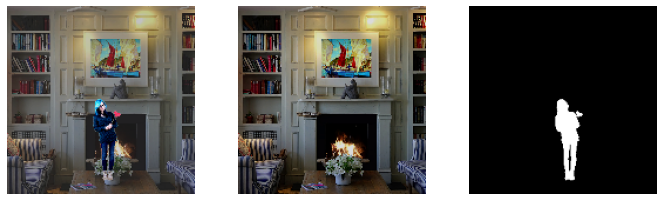

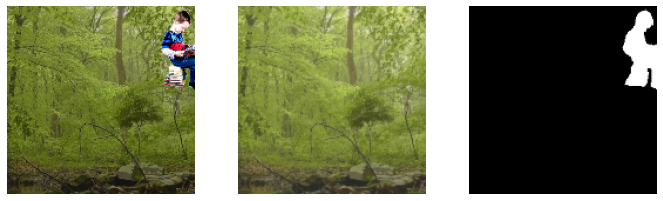

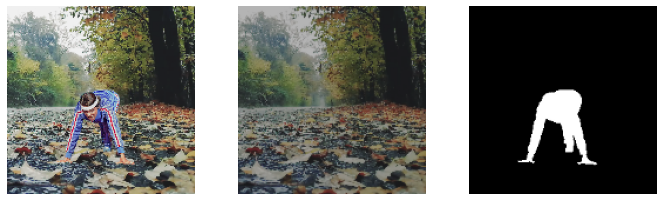

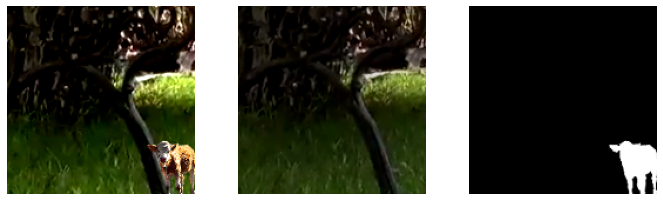

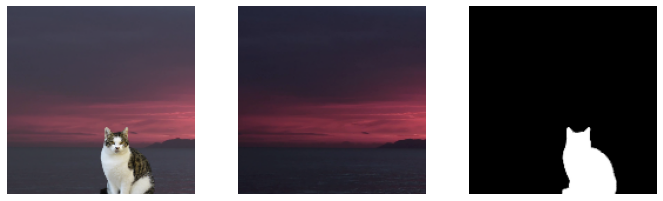

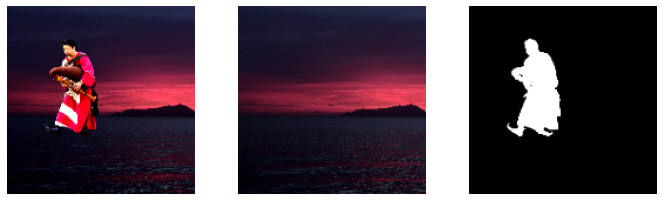

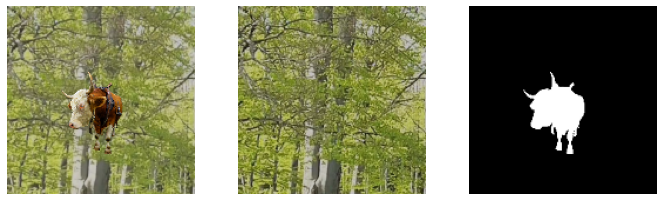

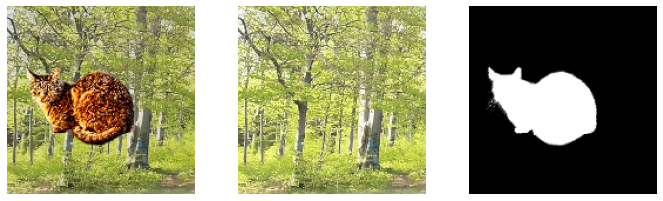

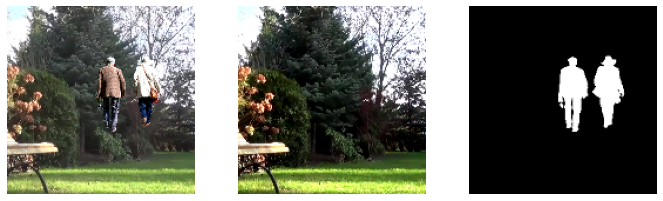

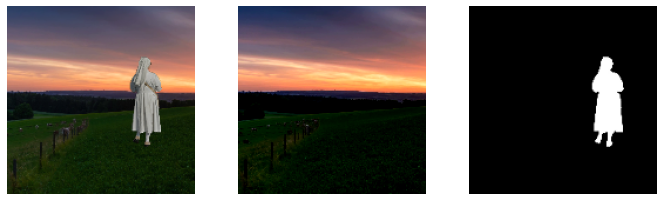

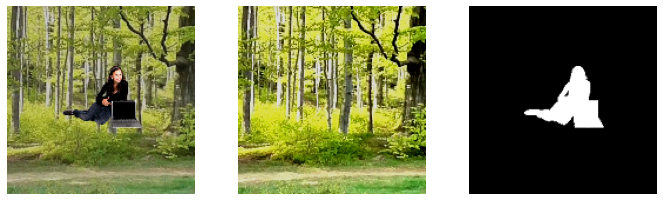

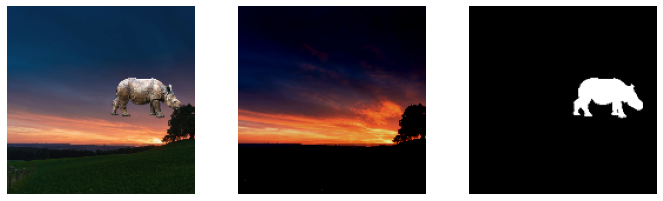

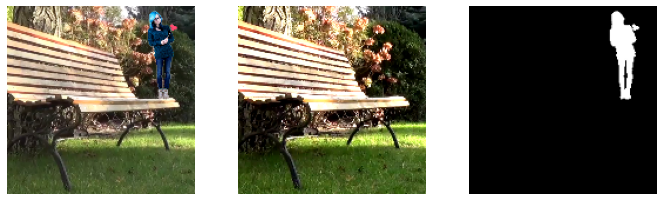

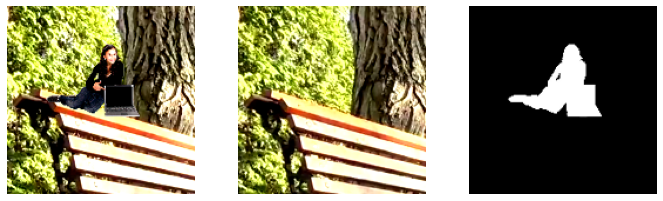

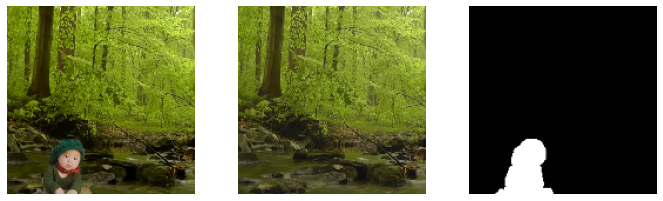

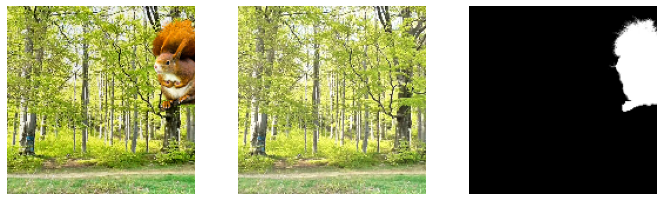

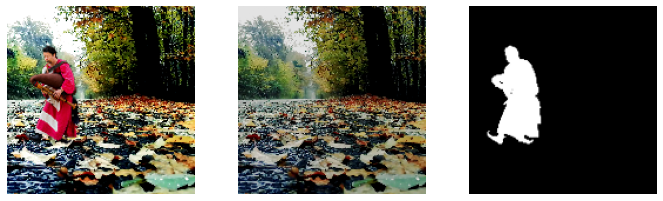

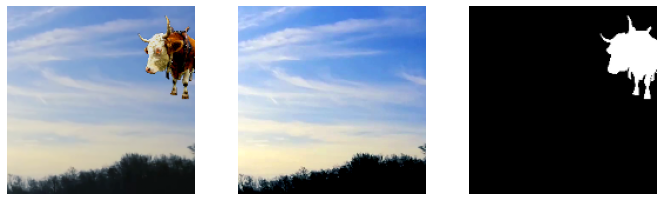

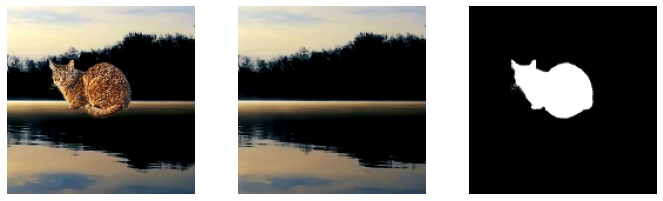

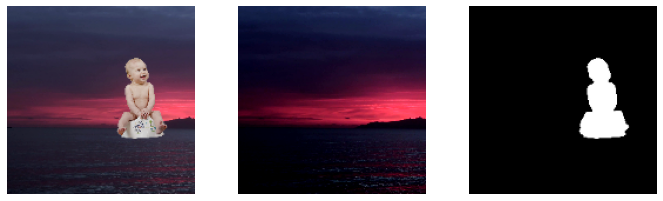

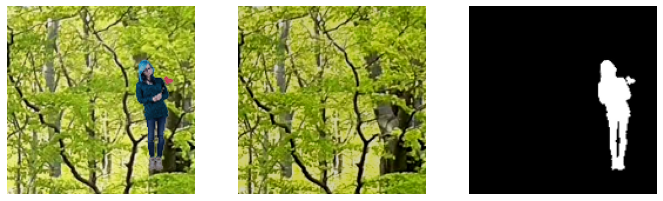

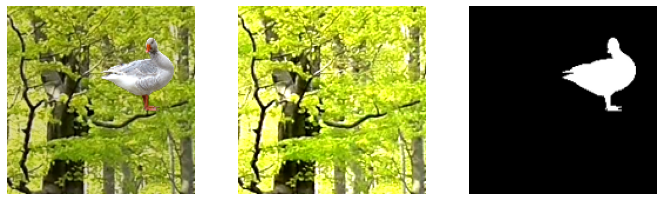

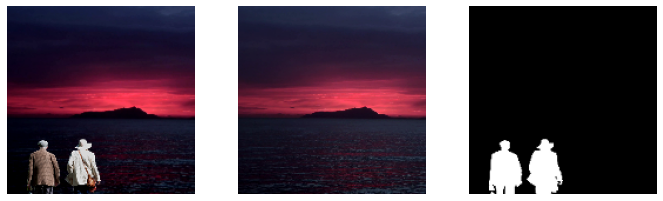

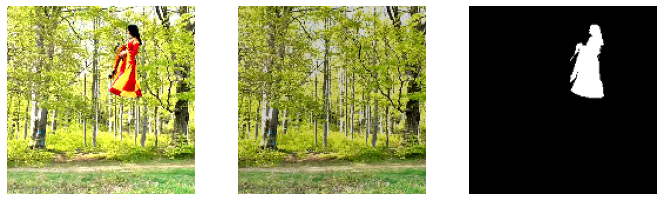

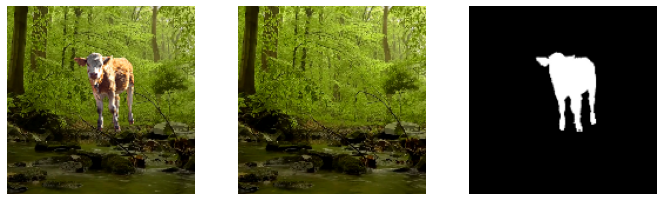

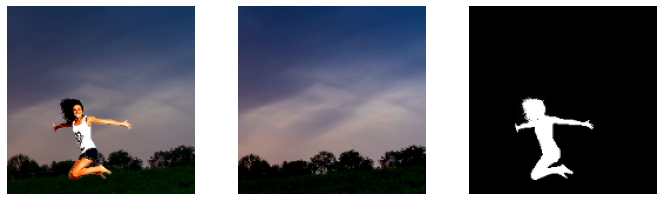

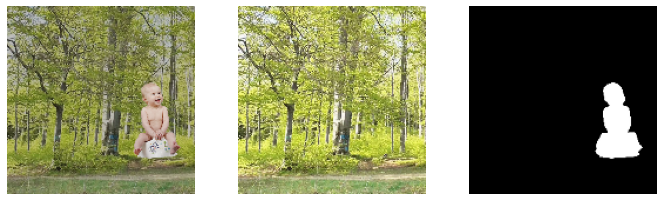

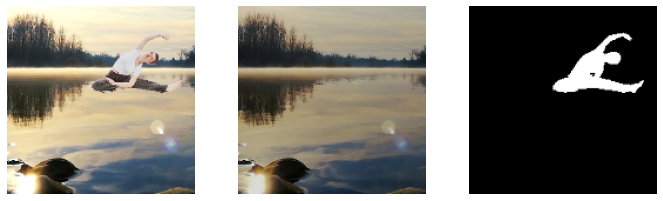

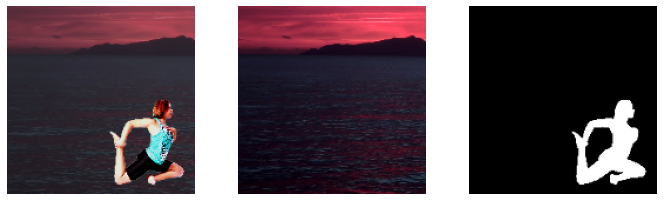

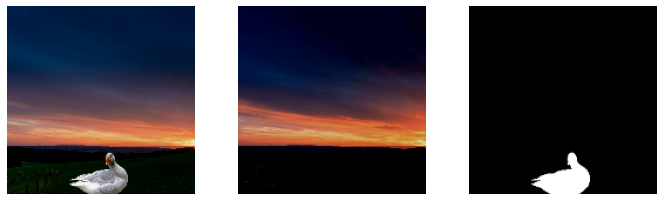

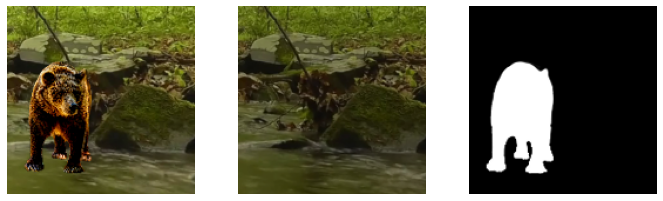

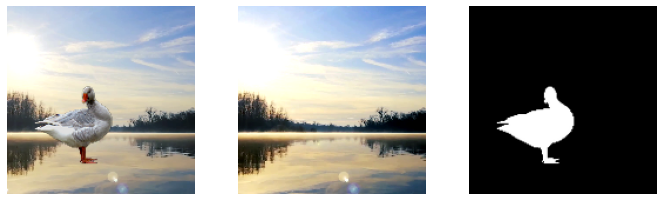

In [ ]:
for output in generator:
    (input1, input2), label = output
    for i in range(len(input1)):
        show_img_mult([input1[i], input2[i], label[i]])
    break

In [ ]:
def pyramid_pooling_module(x):
  pool1 = l.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
  pool1 = l.Conv2D(10,1, activation='relu')(pool1)
  pool1 = l.UpSampling2D(size=(2,2), interpolation='bilinear')(pool1)

  pool2 = l.MaxPool2D(pool_size=(4,4), strides=(4,4))(x)
  pool2 = l.Conv2D(10,1, activation='relu')(pool2)
  pool2 = l.UpSampling2D(size=(4,4), interpolation='bilinear')(pool2)

  pool3 = l.MaxPool2D(pool_size=(8,8), strides=(8,8))(x)
  pool3 = l.Conv2D(10,1, activation='relu')(pool3)
  pool3 = l.UpSampling2D(size=(8,8), interpolation='bilinear')(pool3)

  pool4 = l.MaxPool2D(pool_size=(16,16), strides=(16,16))(x)
  pool4 = l.Conv2D(10,1, activation='relu')(pool4)
  pool4 = l.UpSampling2D(size=(16,16), interpolation='bilinear')(pool4)

  output = l.Concatenate(axis=-1)([x, pool1, pool2, pool3, pool4])

  return output

def create_pp_based_model_alpha_out_relu():
    input1 = l.Input(shape=[160,160,3])
    input2 = l.Input(shape=[160,160,3])
    input_concat = l.Concatenate(axis=-1)([input1, input2])
    z = l.Conv2D(32, 3,  activation='relu', padding='same')(input_concat)
    z = l.Conv2D(32, 3,  activation='relu', padding='same')(z)
    z = pyramid_pooling_module(z)
    z = l.Concatenate(axis=-1)([z, input1, input2])
    z = l.SeparableConv2D(32, 3,  activation='relu', padding='same')(z)
    z = l.Conv2D(1, 1,  activation='relu', padding='same')(z)
    return keras.Model(inputs=[input1,input2], outputs=[z])

In [ ]:
model5 = create_pp_based_model_alpha_out_relu()
model5.compile(loss='MSE', optimizer=keras.optimizers.Adam(1e-3), metrics=["MAE"])
model5.fit_generator(generator=generator, epochs=10, use_multiprocessing=True)
model5.save('/content/gdrive/MyDrive/Colab Notebooks/Green Screen/models/model5_30epoch_advDataGen')


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1000/1000 [==============================] - 340s 339ms/step - loss: 0.0227 - MAE: 0.0489
Epoch 2/10
1000/1000 [==============================] - 341s 341ms/step - loss: 0.0086 - MAE: 0.0196
Epoch 3/10
1000/1000 [==============================] - 341s 341ms/step - loss: 0.0065 - MAE: 0.0152
Epoch 4/10
1000/1000 [==============================] - 342s 342ms/step - loss: 0.0060 - MAE: 0.0138
Epoch 5/10
1000/1000 [==============================] - 342s 342ms/step - loss: 0.0056 - MAE: 0.0127
Epoch 6/10
1000/1000 [==============================] - 343s 343ms/step - loss: 0.0050 - MAE: 0.0116
Epoch 7/10
1000/1000 [==============================] - 344s 344ms/step - loss: 0.0044 - MAE: 0.0104
Epoch 8/10
1000/1000 [==============================] - 343s 343ms/step - loss: 0.0044 - MAE: 0.0102
Epoch 9/10
1000/1000 [==============================] - 342s 342ms/step - loss: 0.0039 - MAE: 0.0094
Epoch 10/10
1000/1000 [==============================] - 341s 341ms/step - loss: 0.0039 - M

In [ ]:
for output in generator:
    (input1, input2), label = output    
    model_out = model5.predict((input1, input2))
    for i in range(5):
        show_img_mult([input1[i], input2[i], model_out[i] * input1[i], label[i], model_out[i]])

    break